In [ ]:
############ LOAD in custom packages ################
import sys
import importlib
import os
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt


# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path
sys.path.append(project_root)

# Import and reload custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import feature_selection as fs
from scripts import clustering as cl
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(fs)
importlib.reload(cl)


### Load in packages and variables
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common 
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols




In [124]:
#### Simple linear regression
from sklearn.linear_model import LinearRegression
# Step 1: Set x_cols to the various V1 PCs
y_var = 'pc_depression'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
results = pd.DataFrame()
count=0
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
y_col = [y_var]

reg = LinearRegression().fit(data[x_cols], data[y_col])
print(reg.score(data[x_cols], data[y_col]))
print(reg.coef_)
print(reg.intercept_)

0.0033118877990261364
[[-0.05241792  0.0875165   0.03649243 -0.01783263]]
[0.01085215]


In [ ]:
######### Mixed LM Model V1 vs phq2_sum #########
###### V1 PCs vs phq2_sum #########
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import statsmodels.formula.api as smf

y_var = 'pc_depression'
data = pd.read_csv(os.path.join(brighten_dir, 'v1_day_pca.csv'))
results = pd.DataFrame()
count=0
x_cols = [col for col in data.columns.to_list() if 'pc_' in col and col!=y_var]
y_col = [y_var]
data_full = data.dropna(subset=x_cols + y_col + ['num_id'])
data_full = data_full.copy()
model = smf.mixedlm(f"{y_var} ~ pc_calls + pc_mobility + pc_missed_communications + pc_sms ", 
                    data=data_full, 
                    groups=data_full["num_id"],)
result = model.fit()
print(f'X cols {x_cols} relationship to y_col {y_col},  Nested Linear Regression')
print(result.summary())

X cols ['pc_mobility', 'pc_missed_communications', 'pc_calls', 'pc_sms'] relationship to y_col ['pc_depression'],  Nested Linear Regression
               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   pc_depression
No. Observations:     5101      Method:               REML         
No. Groups:           195       Scale:                1.9591       
Min. group size:      1         Log-Likelihood:       -9193.9343   
Max. group size:      167       Converged:            Yes          
Mean group size:      26.2                                         
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                -0.028    0.080 -0.354 0.723 -0.184  0.128
pc_calls                  0.054    0.023  2.320 0.020  0.008  0.099
pc_mobility              -0.066    0.026 -2.502 0.012 -0.11

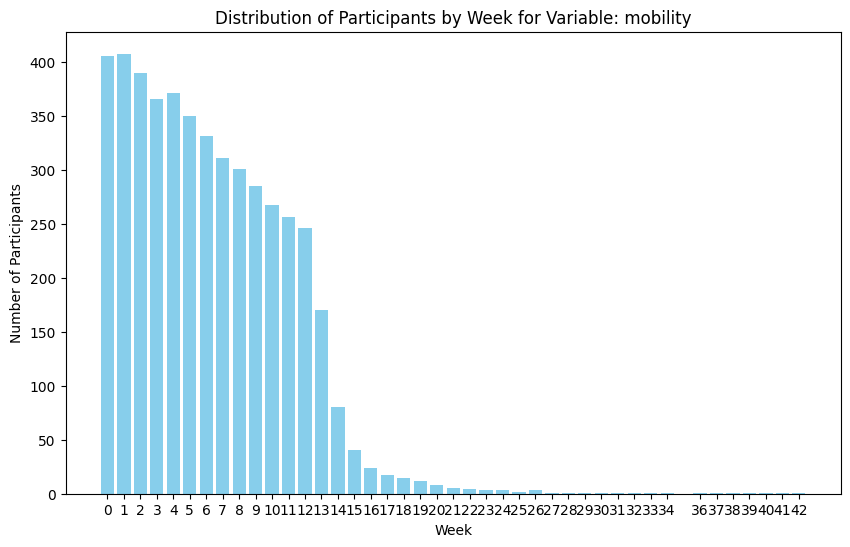

(297, 44)


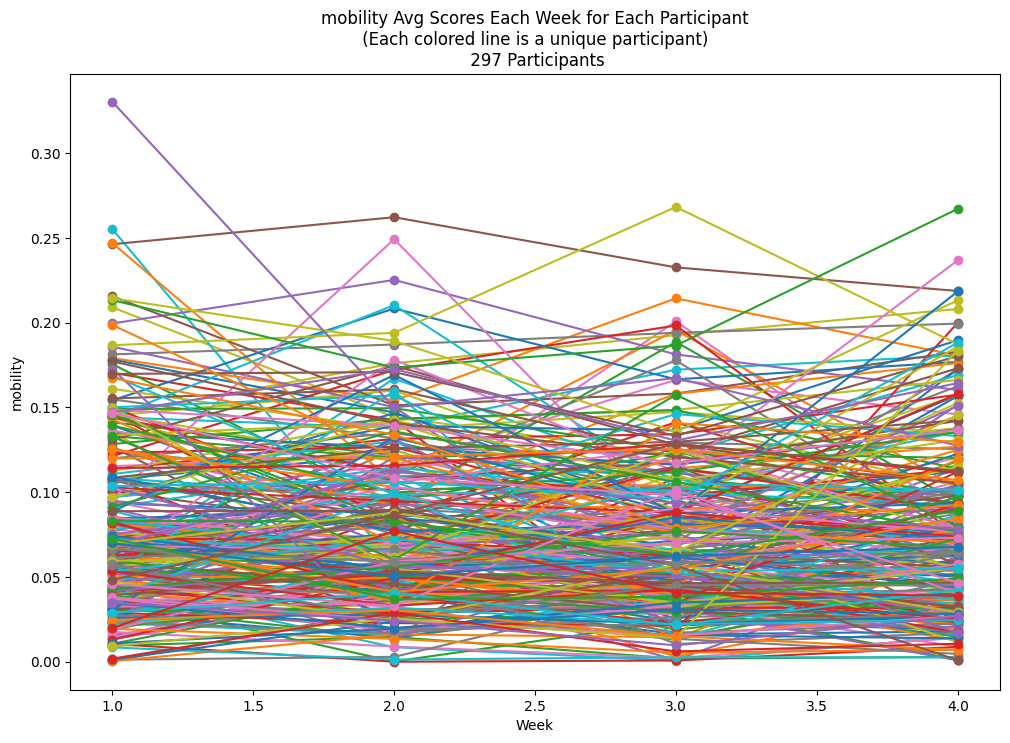

In [ ]:
##### Cluster independent variables into high/low clusters

### MULTI-TIME DTW DISTANCE MATRIX 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from fastdtw import dtw

scaled_df_alldays_int70 = pd.read_csv(os.path.join(brighten_dir, 'scaled_df_alldays_int70.csv'))
scaled_df_week_int70 = pd.read_csv(os.path.join(brighten_dir, 'scaled_df_week_int70.csv'))

# Step 0: Choose a Y-variable to cluster & import data
cluster_variable = 'mobility' #choose y_col
cluster_label_name = 'mobility_cluster'
# mobility, distance_active, distance_walking, hours_active, hours_stationary, location_variance, 



# Step 1: Filter whole DF to just include that week
var_df = scaled_df_alldays_int70[['participant_id', 'week', cluster_variable]]

# Step 3 [only for weekly vars]: Group by participant and week and compute the average of mood_var
grouped_df = var_df.groupby(['participant_id', 'week'], as_index=False)[cluster_variable].mean()

# Step 2: Drop rows (participant/week) who have NA values for mean mood_var from that week
cleaned_df = grouped_df.dropna(subset=[cluster_variable])

# Step 4: Count the number of participants for each unique week
week_counts = cleaned_df['week'].value_counts().sort_index()

# Step 5: Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(week_counts.index, week_counts.values, color='skyblue')
plt.xlabel('Week')
plt.ylabel('Number of Participants')
plt.title(f'Distribution of Participants by Week for Variable: {cluster_variable}')
plt.xticks(week_counts.index)  # Set x-axis ticks to match week numbers
plt.show()

# Step 6: Based on histogram, determine the set of required weeks
# # 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0
required_weeks = [1.0, 2.0, 3.0, 4.0]

# Step 7: Pivot the DataFrame to create a matrix with participants as rows and weeks as columns
pivot_df = grouped_df.pivot(index='participant_id', columns='week', values=cluster_variable)

# Step 8: Reset the index if needed
pivot_df = pivot_df.reset_index()

# Step 10: Get only the (numeric) columns that correspond to the required weeks
week_columns = [week for week in required_weeks if week in pivot_df.columns]

# # Step 11: Filter participants who have all required weeks
filtered_df = pivot_df[pivot_df[week_columns].notna().all(axis=1)]

# filtered_df = pivot_df[cleaned_df['week'] <= 4]

# Step 12: Print the number of participants for that week-range and Y-variable
print(filtered_df.shape)

# Step 13 [optional]: Plot graph of the mood_var scores of participants for those weeks
plt.figure(figsize=(12, 8))
for index, row in filtered_df.iterrows():
    plt.plot(week_columns, row[week_columns], marker='o', label=f'Participant {row["participant_id"]}')

# Customize plot appearance
plt.xlabel('Week')
plt.ylabel(cluster_variable)
plt.title(f'{cluster_variable} Avg Scores Each Week for Each Participant\n (Each colored line is a unique participant) \n {filtered_df.shape[0]} Participants')
plt.show()

In [ ]:

#### Create Distance matrix ####
# Step 0: Drop participant_id column & any columns not in date range
required_weeks_list = [float(num) for num in required_weeks]
var_weeks = filtered_df[required_weeks_list]

# Step 1: Compute the DTW distance matrix
distance_matrix = np.zeros((len(var_weeks), len(var_weeks)))
for i in range(len(var_weeks)):
    for j in range(i+1, len(var_weeks)):
        distance = dtw(var_weeks.iloc[i], var_weeks.iloc[j])
        distance_matrix[j][i] = distance_matrix[i][j] = distance[0]



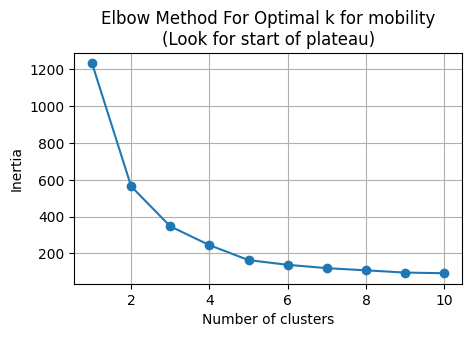

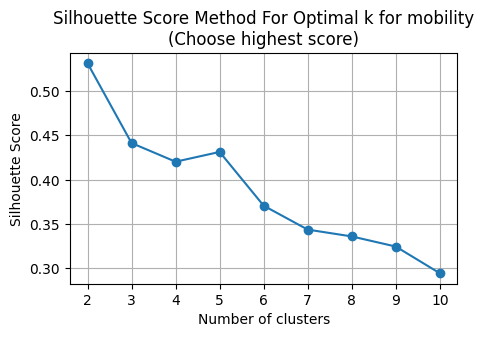

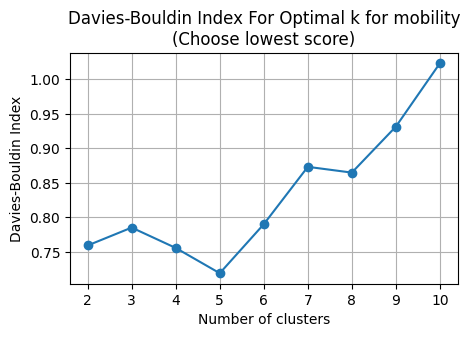

In [ ]:
### Evaluate numbers of clusters with various methods


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# If it's for baseline, change distance_matrix -> distance_matrix_bl 

# Define the range of clusters
inertia = []
range_n_clusters = range(1, 11)  # For example, testing 1 to 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(distance_matrix)  # Use your distance matrix or just the data
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title(f'Elbow Method For Optimal k for {cluster_variable}\n(Look for start of plateau)')
plt.grid()
plt.show()

### Evaluate cluster numbers with silhouette_score

from sklearn.metrics import silhouette_score

silhouette_scores = []

for n_clusters in range_n_clusters[1:]:  # Start from 2 clusters for silhouette score
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(distance_matrix)
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters[1:], silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score Method For Optimal k for {cluster_variable}\n(Choose highest score)')
plt.grid()
plt.show()

### Evaluate cluster numbers with davies_bouldin_score

from sklearn.metrics import davies_bouldin_score

davies_bouldin_scores = []

for n_clusters in range_n_clusters[1:]:  # Start from 3 clusters for DBI
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(distance_matrix)
    db_index = davies_bouldin_score(distance_matrix, cluster_labels)
    davies_bouldin_scores.append(db_index)

# Plot Davies-Bouldin Index
plt.figure(figsize=(5, 3))
plt.plot(range_n_clusters[1:], davies_bouldin_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title(f'Davies-Bouldin Index For Optimal k for {cluster_variable}\n(Choose lowest score)')
plt.grid()
plt.show()




(297,)
(297, 45)
week
1.0    0.139672
2.0    0.136207
3.0    0.126108
4.0    0.137715
dtype: float64


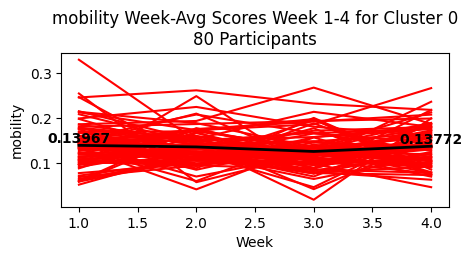

week
1.0    0.058810
2.0    0.057967
3.0    0.054880
4.0    0.057242
dtype: float64


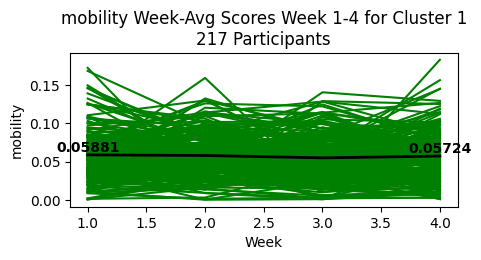

In [ ]:
######### DTW-K CLUSTERING for variable responses 
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Perform KMeans clustering
clusters=2
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(distance_matrix)
print(kmeans.labels_.shape)
print(filtered_df.shape)

# Step 2: Add cluster labels to df
filtered_df[cluster_label_name] = kmeans.labels_
cluster_df = scaled_df_alldays_int70.merge(filtered_df[[cluster_label_name, 'participant_id']], on=['participant_id'], how='left')

# Step 3: Visualize the clusters
colors = ['red', 'green', 'blue', 'yellow','orange','brown']

for cluster in range(clusters):
     # Create a new figure for each cluster
    fig, ax = plt.subplots(figsize=(5, 2))

    # Get indices of participants belonging to the current cluster
    cluster_indices = [i for i, label in enumerate(kmeans.labels_) if label == cluster]
    cluster_data = var_weeks.iloc[cluster_indices]
    
    # Plot each participant in the current cluster
    for i in cluster_indices:
        ax.plot(var_weeks.iloc[i], color=colors[cluster], label=f'Participant {i}' if i == cluster_indices[0] else "")
    
    # Plot the average for that cluster
    avg_line = cluster_data.mean(axis=0)  # Mean across rows for each week
    print(avg_line)
    ax.plot(range(1, len(avg_line) + 1), avg_line, color='black', linewidth=2, label='Average')
    # Label the score at the beginning and end of the average line
    ax.text(1, avg_line.iloc[0], f"{avg_line.iloc[0]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    ax.text(len(avg_line), avg_line.iloc[-1], f"{avg_line.iloc[-1]:.5f}", color='black', ha='center', va='bottom', fontweight='bold')
    
    # Add a legend with cluster labels and custom title
    ax.set_xlabel('Week')
    ax.set_ylabel(cluster_variable)
    ax.set_title(f'{cluster_variable} Week-Avg Scores Week 1-4 for Cluster {cluster}\n{len(cluster_indices)} Participants')
    
    # Show the plot for the current cluster
    plt.show()

cluster_df.to_csv(os.path.join(brighten_dir, f'{cluster_label_name}.csv'))



For v1_day
11 high mobility participants
103 low mobility participants


For v1_week_phq9
11 high mobility participants
100 low mobility participants


For v1_week_phq2
11 high mobility participants
104 low mobility participants


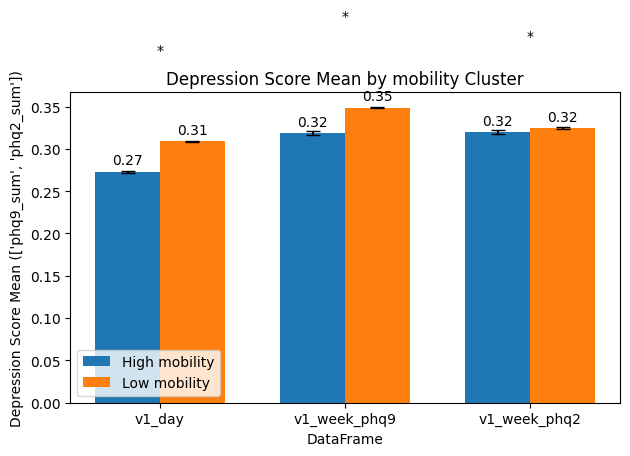

In [ ]:

# merge regressed/scaled dfs with the clusters
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind  # For significance testing

# Initialize lists to store the means, errors, and labels for the bar chart
high_means = [] # high, med high, med, med low, low
low_means = []
high_errors = []
low_errors = []
labels = []
p_values = []  # To store p-values from the significance test
effect_sizes = [] # To store effect sizes

# Variable 
X_var = cluster_label_name # name + '_cluster' in csv, mobility (mobility), distance_active (DA), distance_walking (DW), hours_active (HA), hours_stationary (HS), location_variance (LV)
X_var_name = cluster_variable

y_var = ['phq9_sum', 'phq2_sum'] #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
y_var_name = 'Depression Score'

for name, df in dfs_scaled.items():
    df_with_cluster = df.merge(cluster_df[['participant_id',X_var]], on=['participant_id'], how='inner')
    # High mobility
    high_df = df_with_cluster[df_with_cluster[X_var]==0]
    # Low mobility
    low_df = df_with_cluster[df_with_cluster[X_var]==1]

    if high_df.shape[0] > 0 and low_df.shape[0] > 0:
        print(f'\n\nFor {name}')

        for i in range(len(y_var)):
            if y_var[i] in df.columns:
                high_clean = high_df[[y_var[i],'participant_id']].dropna()
                high = high_clean[y_var[i]]
                low_clean = low_df[[y_var[i],'participant_id']].dropna()
                low = low_clean[y_var[i]]

                # Count participants in each group
                highN, lowN = high.shape[0], low.shape[0]
            
                # Calculate means and standard errors
                high_mean, low_mean = high.mean(), low.mean()
                high_error, low_error = high.sem(), low.sem()  # Standard error of the mean
                high_std, low_std = high.std(ddof=1), low.std(ddof=1)
                # Calculate pooled SD
                pooled_sd = np.sqrt(((highN - 1) * high_std**2 + (lowN - 1) * low_std**2) / (highN + lowN - 2))

                # Append the means, errors, and labels to the lists
                high_means.append(high_mean)
                low_means.append(low_mean)
                high_errors.append(high_error)
                low_errors.append(low_error)
                labels.append(name)

                # Perform significance test (independent t-test)
                t_stat, p_value = ttest_ind(high, low, equal_var=False)  # Welch's t-test (unequal variances)
                p_values.append(p_value)

                # Perform effect-size test
                cohens_d = (high_mean - low_mean) / pooled_sd
                effect_sizes.append(cohens_d)

                print(f"{len(high_clean['participant_id'].unique())} high {X_var_name} participants, mean score {high_mean:.2f} ± {high_error:.2f}")
                print(f"{len(low_clean['participant_id'].unique())} low {X_var_name} participants, mean score {low_mean:.2f} ± {low_error:.2f}")
                print(f'p-value for difference: {p_value:.4f}')
                print(f'effect-size for difference: {cohens_d:.2f}')

# Plotting the bar chart
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, high_means, width, yerr=high_errors, capsize=5, label=f'High {X_var_name}')
rects2 = ax.bar(x + width/2, low_means, width, yerr=low_errors, capsize=5, label=f'Low {X_var_name}')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('DataFrame')
ax.set_ylabel(f'{y_var_name} Mean ({y_var})')
ax.set_title(f'{y_var_name} Mean by {X_var_name} Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add significance annotations
for i, p_value in enumerate(p_values):
    if p_value < 0.05:  # Add annotation only if p-value is significant
        ax.text(x[i], max(high_means[i], low_means[i]) + 0.1, '*', ha='center', va='bottom')

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()



For v1_day
49 low mobility participants
44 medium_low mobility participants
16 medium mobility participants
4 medium_high mobility participants
1 high mobility participants


For v1_week_phq9
48 low mobility participants
42 medium_low mobility participants
16 medium mobility participants
4 medium_high mobility participants
1 high mobility participants


For v1_week_phq2
50 low mobility participants
44 medium_low mobility participants
16 medium mobility participants
4 medium_high mobility participants
1 high mobility participants


IndexError: list index out of range

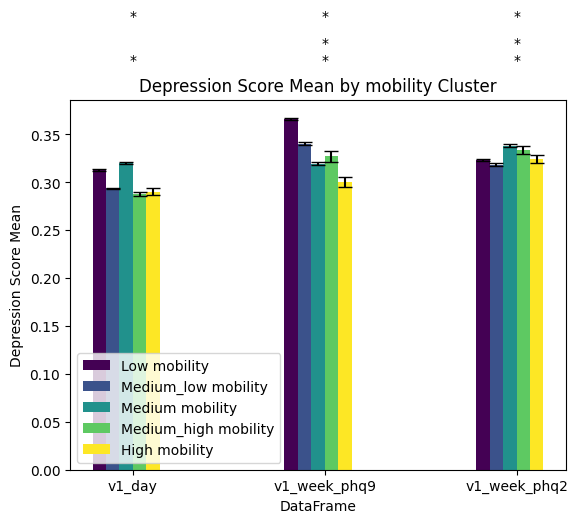

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind  # For significance testing

# Dictionary to map cluster descriptions to cluster numbers
cluster_mapping = {
    "low": 1,
    "medium_low": 3,
    "medium": 0,
    "medium_high": 4,
    "high":2
    # Add more mappings as needed, e.g., "med high": 0, "med": 1, "med low": 2, "low": 3
}

# Initialize lists to store the means, errors, and labels for the bar chart
cluster_means = {desc: [] for desc in cluster_mapping.keys()}
cluster_errors = {desc: [] for desc in cluster_mapping.keys()}
labels = []
p_values = []  # To store p-values from the significance test

# Variable 
X_var = cluster_label_name # name + '_cluster' in csv, mobility (mobility), distance_active (DA), distance_walking (DW), hours_active (HA), hours_stationary (HS), location_variance (LV)
X_var_name = cluster_variable

y_var = ['phq9_sum', 'phq2_sum'] #mood_1, sds_1, sds_2, sds_3, phq9_sum, phq2_sum
y_var_name = 'Depression Score'

for name, df in dfs_scaled.items():
    df_with_cluster = df.merge(cluster_df[['participant_id', X_var]], on=['participant_id'], how='inner')
    
    # Initialize dictionaries to store data for each cluster
    cluster_data = {desc: df_with_cluster[df_with_cluster[X_var] == num] for desc, num in cluster_mapping.items()}
    
    if all(len(cluster_data[desc]) > 0 for desc in cluster_mapping.keys()):
        print(f'\n\nFor {name}')

        for i in range(len(y_var)):
            if y_var[i] in df.columns:
                # Calculate means and standard errors for each cluster
                for desc, data in cluster_data.items():
                    clean_data = data[[y_var[i], 'participant_id']].dropna()
                    cluster_values = clean_data[y_var[i]]
                    
                    cluster_mean = cluster_values.mean()
                    cluster_error = cluster_values.sem()  # Standard error of the mean
                    
                    cluster_means[desc].append(cluster_mean)
                    cluster_errors[desc].append(cluster_error)
                    
                    print(f"{len(clean_data['participant_id'].unique())} {desc} {X_var_name} participants")

                # Perform significance test (independent t-test) between all pairs of clusters
                for j in range(len(cluster_mapping) - 1):
                    for k in range(j + 1, len(cluster_mapping)):
                        desc1 = list(cluster_mapping.keys())[j]
                        desc2 = list(cluster_mapping.keys())[k]
                        t_stat, p_value = ttest_ind(cluster_data[desc1][y_var[i]], cluster_data[desc2][y_var[i]], equal_var=False)
                        p_values.append(p_value)

                labels.append(name)

# Plotting the bar chart
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_mapping)))  # Generate colors for each cluster

rects = []
for i, (desc, color) in enumerate(zip(cluster_mapping.keys(), colors)):
    rect = ax.bar(x + (i - len(cluster_mapping) / 2) * width / len(cluster_mapping), 
                  cluster_means[desc], width / len(cluster_mapping), 
                  yerr=cluster_errors[desc], capsize=5, label=f'{desc.capitalize()} {X_var_name}', color=color)
    rects.append(rect)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('DataFrame')
ax.set_ylabel(f'{y_var_name} Mean')
ax.set_title(f'{y_var_name} Mean by {X_var_name} Cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add significance annotations
for i, p_value in enumerate(p_values):
    if p_value < 0.05:  # Add annotation only if p-value is significant
        ax.text(x[i % len(labels)], max([cluster_means[desc][i // len(labels)] for desc in cluster_mapping.keys()]) + 0.1, '*', ha='center', va='bottom')

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        for r in rect:
            height = r.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(r.get_x() + r.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()

plt.show()

In [ ]:
# ##### Cluster subjects into network subtypes
# #### Save each sub's V1 symptom correlation distance matrix into v1_symptom_matrices

# def flatten_matrix(corr_matrix):
#     indices = []
#     for i in range(corr_matrix.shape[0]):
#         for j in range(i, corr_matrix.shape[1]):
#             if not i==j:
#                 indices.append([i,j])
#     return [corr_matrix.iloc[row, col] for row, col in indices]

# def upper_triangle(corr_matrix):
#     indices = []
#     for i in range(corr_matrix.shape[0]):
#         for j in range(i, corr_matrix.shape[1]):
#             if not i==j:
#                 indices.append([i,j])
#     return indices

# for name, df in d
# #full_df_v1 = full_df_v1.drop(columns='aggregate_communication_scaled')
# subs = full_df_v1['participant_id'].unique()
# print(f'In full_dt_v1 there are {len(subs)} subjects.')

# flattened_sub_matrices = {}
# v1_symptom_matrices = {}
# subs2 = []
# for sub in subs:
#     data = full_df_v1[full_df_v1['participant_id']==sub] # filter for each specific sub
#     # keep only numerical/changing columns
#     keep_columns = [var for var in full_df_v1.columns.to_list() if var.startswith('pc_')]
#     data = data[keep_columns] 
#     # transform into correlation matrix
#     correlation_matrix = data.corr() 
#     # Replace inf/-inf with NaN
#     correlation_matrix = correlation_matrix.replace([float('inf'), -float('inf')], pd.NA)  
#     # drop resulting NaNs
#     correlation_matrix = correlation_matrix.dropna() 
#     # add subs with non-empty matrices to subs2
#     if not correlation_matrix.empty:
#         subs2.append(sub) 
#          # add entire corr matrix to list
#         v1_symptom_matrices[sub] = correlation_matrix
#         # extract unique values from upper triangle into vector
#         vector = flatten_matrix(correlation_matrix) 
#          # add nonzero vector to list
#         if not len(vector)==0:
#             flattened_sub_matrices[sub] = vector

#         # # Heatmap
#         # plt.figure(figsize=(2, 1))
#         # sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.1f', linewidths=0.5)
#         # plt.title(f"{sub}")
#         # plt.show()

#     #     # Line/Scatter plot
#     #     x = np.arange(len(vector))
#     #     plt.figure(figsize=(2, 1))
#     #     plt.scatter(x, vector, label="Points", color="blue")

    
# # plt.show()


# print(len(flattened_sub_matrices.keys()), 'filled arrays')


# linkage_matrix = linkage(list(flattened_sub_matrices.values()), method='ward', metric='euclidean')
# dendrogram(linkage_matrix, labels=list(flattened_sub_matrices.keys()))
# plt.show()



In [ ]:

# # Step 5: Perform clustering of subjects
# num_clusters = 5
# hierarchical_cluster = AgglomerativeClustering(
#     n_clusters=num_clusters,  # Number of clusters
#     linkage='ward'  # Linkage method
# )

# labels = hierarchical_cluster.fit_predict(linkage_matrix)
# print(labels)

# sub_clusters = dict(zip(flattened_sub_matrices.keys(), labels))